# GENSIM WORD2VEC EXPERIMENT

## TRAINING DATA: BROWN CORPUS
**NB: FOR PREPARATION, DO NOT RUN THIS SECTION FIRST**

In [59]:
from nltk.corpus import brown, stopwords
from nltk.stem.porter import PorterStemmer

In [60]:
%%time
words, sents = list(brown.words()), list(brown.sents())

CPU times: user 11.9 s, sys: 187 ms, total: 12.1 s
Wall time: 12.2 s


In [62]:
stop = stopwords.words('english')

In [63]:
def brown_clean(sents):
    sents = [[str(word.lower()) for word in sent] for sent in sents] # unicode->string, lowercasing.
    sents = [[word for word in sent if word not in stop] for sent in sents] # removing stopwords.
    sents = [[PorterStemmer().stem(word) for word in sent] for sent in sents] # lemmatizing.
    return sents
def brown_vocab_build(words):
    return list(set([PorterStemmer().stem(str(word.lower())) for word in words if str(word.lower()) not in stop]))

In [65]:
%%time
words = brown_vocab_build(words)
words = [str(word) for word in words] # somehow unicode->string needs to be performed again.

CPU times: user 23 s, sys: 204 ms, total: 23.2 s
Wall time: 23.2 s


In [66]:
%%time
sents = brown_clean(sents)

CPU times: user 22.3 s, sys: 197 ms, total: 22.5 s
Wall time: 22.5 s


In [67]:
print sents[0]
print words[0]

[u'fulton', u'counti', u'grand', u'juri', u'said', u'friday', u'investig', u"atlanta'", u'recent', u'primari', u'elect', u'produc', u'``', u'evid', u"''", u'irregular', u'took', u'place', u'.']
fawn


## GENSIM WORD2VEC MODEL

In [372]:
from gensim.models import Word2Vec
    # Word2Vec params:
    #  - size: dimensionality of feature vectors.
    #  - window: the maximum distance between the current and predicted word within a sentence.
    #  - alpha: initial learning rate.
    #  - seed: seed for random number generator.
    #  - min_count: ignore all words with total frequency lower than this.
    #  - max_vocab_size: limit RAM during vocab building.
    #  - sample: threshold for configuring which higher-frequency words are randomly downsampled
    #      default=1e-3, useful range is (0, 1e-5).
    #  - workers: use this many worker threads to train the model (i.e. faster with multicore machines)
    #  - iter: number of iterations over corpus.
    #  ... for the rest see https://radimrehurek.com/gensim/models/word2vec.html.

In [373]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from keras.utils.np_utils import to_categorical
%matplotlib inline

In [374]:
import os
os.chdir('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/OJO/SPAM_INTEREST_TASKS/DATA')

In [375]:
joshdata = pd.read_excel('sentiment_josh.xlsx')
joshdata.head()

,0,1
0,She has indeed contacted me I have n't contact...,1
1,The round of interviews went very well . Still...,2
2,It looks like my first reply might not have go...,2
3,We will be in Austin May NUMBER for the next r...,2
4,- MLS # NUMBER is by far my top choice because...,2


In [376]:
cristinadata = pd.read_excel('sentiment_cristina.xlsx')
jacobdata = pd.read_excel('sentiment_jacob.xlsx')

In [377]:
X = np.concatenate((joshdata[0].values, cristinadata[0].values, jacobdata[0].values))
y = np.concatenate((joshdata[1].values, cristinadata[1].values, jacobdata[1].values))
y[618] = 1.
y[706] = 1.
y[1472] = 1.
y = to_categorical(y)
print X[0]
print y[0]

She has indeed contacted me I have n't contacted her back because I 'm waiting to hear more about my husband 's job opportunity . He will be flying to Austin the day after Easter to continue the interviews and after that we should know more . If you could tell her that I will gladly contact her after that set of interviews that would be great
[ 0.  1.  0.]


In [378]:
def sent_clean(sent):
    sent = nltk.word_tokenize(sent) # still unicode.
#     sent = [word for word in sent if word not in stop] # removing stopwords.
    sent = [PorterStemmer().stem(word.lower()) for word in sent]
    return sent
def build_vocab(sents): # used after sent_clean operation.
    vocab = []
    for sent in sents:
        vocab.extend(sent)
    return list(set(vocab))

In [379]:
X = map(sent_clean, X)
vocab = build_vocab(X)

In [380]:
print X[0]
print vocab[:10]

[u'she', u'ha', u'inde', u'contact', u'me', u'i', u'have', u"n't", u'contact', u'her', u'back', u'becaus', u'i', u"'m", u'wait', u'to', u'hear', u'more', u'about', u'my', u'husband', u"'s", u'job', u'opportun', u'.', u'he', u'will', u'be', u'fli', u'to', u'austin', u'the', u'day', u'after', u'easter', u'to', u'continu', u'the', u'interview', u'and', u'after', u'that', u'we', u'should', u'know', u'more', u'.', u'if', u'you', u'could', u'tell', u'her', u'that', u'i', u'will', u'gladli', u'contact', u'her', u'after', u'that', u'set', u'of', u'interview', u'that', u'would', u'be', u'great']
[u'smtp.homecity.com', u'lolthank', u'number-a', u'6pm', u'oldest', u'hate', u'whose', u'aug', u'sorri', u'deviat']


In [381]:
%%time
model = Word2Vec(X, size=5, window=4) # words -> 10D vecs.

CPU times: user 543 ms, sys: 20.4 ms, total: 563 ms
Wall time: 236 ms


In [382]:
# WORD -> VECTOR
def vectorize(model, sent): # sent -> list word vector in model.
    return [model[word] for word in sent if word in model.vocab]

In [383]:
X_vec = [vectorize(model,sent) for sent in X] # X_vec is now a list of lists of 10D vectors
                                              #                 ^        ^            ^
                                              #                 |        |            |
                                              #               corpus   sentence     word

## MLP

In [384]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.preprocessing import sequence
from sklearn.cross_validation import train_test_split

Average Sentence Length: 64


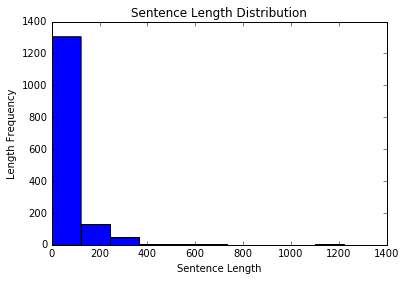

In [385]:
sentLens = [len(sent) for sent in X_vec]
meanLens = int(np.mean(sentLens))
print 'Average Sentence Length: %d' % meanLens
plt.hist(sentLens)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Length Frequency')
plt.show()
# NB: BUT WE'LL TAKE 60.

In [386]:
# INPUT SIZE UNIFORMIZATION
# FLATTENING
def flatten(sents):
    return [word for sent in sents for word in sent]
padding = np.array([0.,0.,0.,0.,0.], dtype='float32')
for i in range(len(X_vec)):
    if len(X_vec[i]) > 60:
        X_vec[i] = X_vec[i][:60]
    else: 
        X_vec[i] += [padding for _ in range(60-len(X_vec[i]))]
X_vec = map(np.array, X_vec) # to np.array, so that .shape attribute is available.
X_vec = map(flatten, X_vec)

In [387]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=.2)

In [388]:
# MLP BUILDING
model = Sequential()
model.add(Dense(100, input_dim=300, init='normal', activation='relu'))
model.add(Dense(50, init='normal', activation='relu'))
model.add(Dense(3, init='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_25 (Dense)                   (None, 100)         30100       dense_input_11[0][0]             
____________________________________________________________________________________________________
dense_26 (Dense)                   (None, 50)          5050        dense_25[0][0]                   
____________________________________________________________________________________________________
dense_27 (Dense)                   (None, 3)           153         dense_26[0][0]                   
Total params: 35303
____________________________________________________________________________________________________
None


In [371]:
%time
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=50, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.11 µs
Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 [==============================] - 0s - loss: 1.0032 - acc: 0.4983 - val_loss: 0.9919 - val_acc: 0.5400
Epoch 2/10
1200/1200 [==============================] - 0s - loss: 0.8997 - acc: 0.6100 - val_loss: 0.9454 - val_acc: 0.5567
Epoch 3/10
1200/1200 [==============================] - 0s - loss: 0.8362 - acc: 0.6417 - val_loss: 0.9236 - val_acc: 0.5600
Epoch 4/10
1200/1200 [==============================] - 0s - loss: 0.7658 - acc: 0.6617 - val_loss: 0.9161 - val_acc: 0.5900
Epoch 5/10
1200/1200 [==============================] - 0s - loss: 0.6986 - acc: 0.6850 - val_loss: 0.8844 - val_acc: 0.5533
Epoch 6/10
1200/1200 [==============================] - 0s - loss: 0.6506 - acc: 0.7117 - val_loss: 0.8613 - val_acc: 0.5767
Epoch 7/10
1200/1200 [==============================] - 0s - loss: 0.6137 - acc: 0.7300 - val_loss: 0.8667 - val_acc: 0.5967
Epoch 8/10